## Import Required Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/42028/ass2/Image_Classification/dataset_24673422/

/content/gdrive/MyDrive/42028/ass2/Image_Classification/dataset_24673422


In [ ]:
%ls /content/gdrive/MyDrive/42028/ass2/Image_Classification/dataset_24673422/

 affenpinscher/      'GURNEYS PITTA'/                   Rottweiler/
'ANDEAN LAPWING'/    'NOISY FRIARBIRD'/                 Scotch_terrier/
'BEARDED REEDLING'/  'NORTHERN BEARDLESS TYRANNULET'/  'SHORT BILLED DOWITCHER'/
 bloodhound/          Norwegian_elkhound/               silky_terrier/
 Border_terrier/      Norwich_terrier/                  Staffordshire_bullterrier/
 Dandie_Dinmont/     'PINK ROBIN'/                     'WHITE EARED HUMMINGBIRD'/
'DAURIAN REDSTART'/   PYRRHULOXIA/


In [ ]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model


## Load Images and Labels

In [ ]:
from PIL import Image
import os
from collections import Counter

# Path to the dataset directory
dataset_path = '/content/gdrive/MyDrive/42028/ass2/Image_Classification/dataset_24673422/'

# Initialize data structures for analysis
class_image_counts = {}
dimensions = []

# Process each subfolder/class in the dataset
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):  # Ensure it's a directory
        image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]
        class_image_counts[class_folder] = len(image_files)

        # Get dimensions of each image
        for image_file in image_files:
            image_path = os.path.join(class_path, image_file)
            with Image.open(image_path) as img:
                dimensions.append(img.size)

# Analyze image dimensions
unique_dimensions = set(dimensions)
dimension_counts = Counter(dimensions)
most_common_dimension = dimension_counts.most_common(1)[0]

# Print out the analysis
print("Total Classes:", len(class_image_counts))
print("Images per class:", class_image_counts)
print("Unique image dimensions:", unique_dimensions)
print("Most common dimension:", most_common_dimension)


Total Classes: 20
Images per class: {'ANDEAN LAPWING': 149, 'BEARDED REEDLING': 149, 'Border_terrier': 172, 'DAURIAN REDSTART': 150, 'Dandie_Dinmont': 180, 'GURNEYS PITTA': 158, 'NOISY FRIARBIRD': 155, 'NORTHERN BEARDLESS TYRANNULET': 173, 'Norwegian_elkhound': 196, 'Norwich_terrier': 185, 'PINK ROBIN': 153, 'PYRRHULOXIA': 180, 'Rottweiler': 152, 'SHORT BILLED DOWITCHER': 159, 'Scotch_terrier': 158, 'Staffordshire_bullterrier': 155, 'WHITE EARED HUMMINGBIRD': 165, 'affenpinscher': 150, 'bloodhound': 187, 'silky_terrier': 183}
Unique image dimensions: {(449, 640), (500, 435), (500, 444), (197, 168), (500, 453), (500, 462), (250, 278), (446, 500), (200, 179), (370, 352), (275, 200), (500, 318), (500, 336), (419, 500), (144, 143), (222, 300), (200, 300), (103, 120), (211, 300), (500, 421), (360, 270), (250, 246), (423, 317), (500, 439), (360, 288), (200, 156), (361, 500), (350, 360), (255, 217), (394, 295), (500, 313), (314, 284), (250, 376), (600, 647), (300, 242), (391, 500), (380, 500)

In [ ]:
def load_images_from_directory(data_dir, target_size=(224, 224)):
    images = []
    labels = []
    class_labels = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d)) and not d.startswith('.')])

    for idx, class_label in enumerate(class_labels):
        class_dir = os.path.join(data_dir, class_label)
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            if os.path.isdir(img_path):  # Skip directories
                continue
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(target_size)
                img_array = np.array(img)
                images.append(img_array)
                labels.append(idx)  # The index of the class label in class_labels
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    return np.array(images), np.array(labels), class_labels

# Now call the function
base_dir = '/content/gdrive/MyDrive/42028/ass2/Image_Classification/dataset_24673422/'

images, labels, class_labels = load_images_from_directory(base_dir)

# Convert labels to one-hot encoding
labels = to_categorical(labels, num_classes=len(class_labels))

In [ ]:
print(images.shape)
print(labels.shape)


(3309, 224, 224, 3)
(3309, 20)


### Visualize Images and Labels

In [ ]:
import matplotlib.pyplot as plt

def plot_sample_images(images, labels, class_labels, num_classes, samples_per_class=1):
    fig, axes = plt.subplots(nrows=num_classes, ncols=samples_per_class, figsize=(samples_per_class*3, num_classes*3))

    # Convert one-hot encoded labels back to class indices for simplicity
    labels_indices = np.argmax(labels, axis=1)

    if num_classes * samples_per_class == 1:
        axes = [axes]

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    # Create a list to store picked indices to avoid picking the same image more than once
    picked_indices = []

    # Loop over each class
    for class_idx in range(num_classes):
        # Find indices of images belonging to the current class
        class_indices = [i for i, label_idx in enumerate(labels_indices) if label_idx == class_idx]
        # Pick random samples
        sample_indices = np.random.choice(class_indices, size=samples_per_class, replace=False)
        for i, idx in enumerate(sample_indices):
            if idx in picked_indices:
                continue
            picked_indices.append(idx)
            ax = axes[class_idx * samples_per_class + i]
            ax.imshow(images[idx] / 255.0)  # Normalize images to [0, 1] for displaying
            ax.set_title(f"Class: {list(class_labels)[class_idx]}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming `images`, `labels`, and `class_labels` are already defined and loaded
plot_sample_images(images, labels, class_labels, num_classes=len(class_labels))


Output hidden; open in https://colab.research.google.com to view.

## Split Dataset

In [ ]:
# Split data into train+validation and test sets
train_val_images, test_images, train_val_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=24673422, stratify=labels)

# Further split train+validation into train and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_val_images, train_val_labels, test_size=0.25, random_state=24673422, stratify=train_val_labels)


## Baseline MobileNetV2 Architecture

### Data Generation

In [ ]:
# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
validation_generator = validation_datagen.flow(val_images, val_labels, batch_size=32)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=32, shuffle=False)

### Baseline Architecture: Model Setting and Summary

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
# Load the MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Make all layers in the base model trainable
for layer in base_model.layers:
    layer.trainable = True

# Adding custom layers on top of the base model
model = Sequential([
    base_model,  # Add the pre-trained base model
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),  # Adding dropout for regularization
    Dense(len(class_labels), activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 20)                20500     
                                                                 
Total params: 3590228 (13.70 MB)
Trainable params: 35561

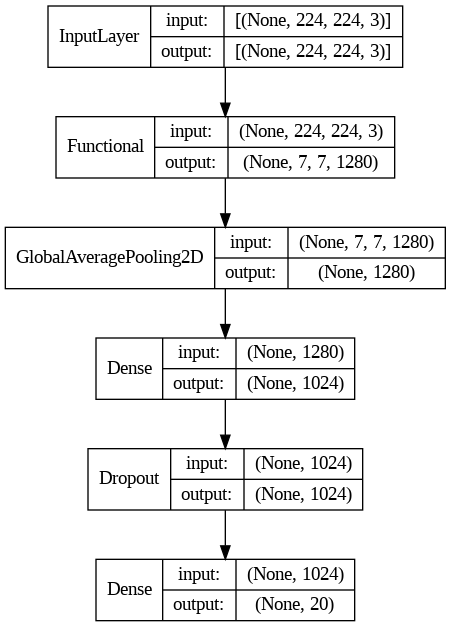

In [ ]:
# Using Plot_Model from Keras.Utils
model_img_file = '/content/gdrive/MyDrive/42028/ass2/Image_Classification/Baseline-model.png'
tf.keras.utils.plot_model(model, to_file=model_img_file,
                          show_shapes=True,
                          show_layer_activations=False,
                          show_dtype=False,
                          show_layer_names=False )

### Checkpointing

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Define the checkpoint callback
checkpoint_path = "/content/gdrive/MyDrive/42028/ass2/Image_Classification/weights/base_model_epoch_{epoch:02d}-val_accuracy_{val_accuracy:.2f}.h5"  # Save models with the epoch number in filename
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')

### Training the baseline model

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[checkpoint])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 1.3926 - accuracy: 0.6458
Epoch 1: saving model to /content/gdrive/MyDrive/42028/ass2/Image_Classification/weights/base_model_epoch_01-val_accuracy_0.88.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 46s 208ms/step - loss: 1.3926 - accuracy: 0.6458 - val_loss: 0.4018 - val_accuracy: 0.8837
Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 0.2302 - accuracy: 0.9451
Epoch 2: saving model to /content/gdrive/MyDrive/42028/ass2/Image_Classification/weights/base_model_epoch_02-val_accuracy_0.90.h5
63/63 [==============================] - 12s 183ms/step - loss: 0.2302 - accuracy: 0.9451 - val_loss: 0.3014 - val_accuracy: 0.9018
Epoch 3/100
63/63 [==============================] - ETA: 0s - loss: 0.1045 - accuracy: 0.9743
Epoch 3: saving model to /content/gdrive/MyDrive/42028/ass2/Image_Classification/weights/base_model_epoch_03-val_accuracy_0.90.h5
63/63 [==============================] - 13s 197ms/step - loss: 0.1045 - accuracy: 0.9743 - val_loss: 0.2842 - val_accuracy: 0.9048
Epoch 4/100
63/63 [==============================] - ETA: 0s - loss: 0.0555 - accuracy: 0.9889
Epoch 4: saving model to /content/gdrive/MyDrive/42028/ass2

### Visualize the results

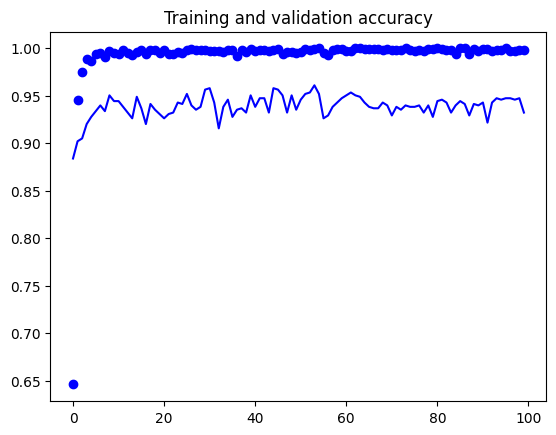

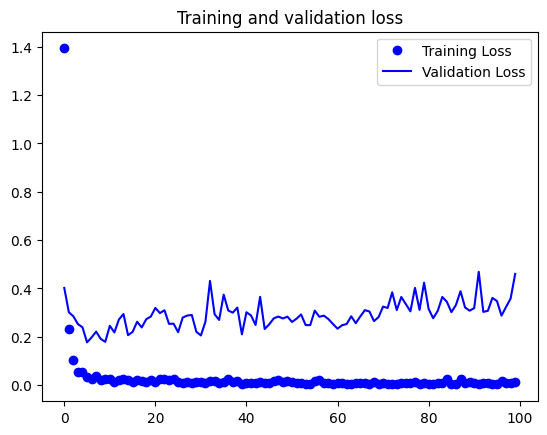

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Extracting training and validation loss and accuracies
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Since we train for 100 epochs, we take the last values for train and validation
final_train_acc = train_acc[-1]
final_val_acc = val_acc[-1]
final_train_loss = train_loss[-1]
final_val_loss = val_loss[-1]

# Creating a DataFrame
base_performance_df = pd.DataFrame({
    'Set': ['Train', 'Validation', 'Test'],
    'Loss': [final_train_loss, final_val_loss, test_loss],
    'Accuracy': [final_train_acc, final_val_acc, test_acc]
})

# Display the table
print(base_performance_df)


# Optionally, save the table to a CSV file
# performance_df.to_csv('/mnt/data/baseline_performance.csv', index=False)


          Set      Loss  Accuracy
0       Train  0.013428  0.997985
1  Validation  0.459963  0.932024
2        Test  0.277068  0.945619


21/21 [==============================] - 2s 47ms/step


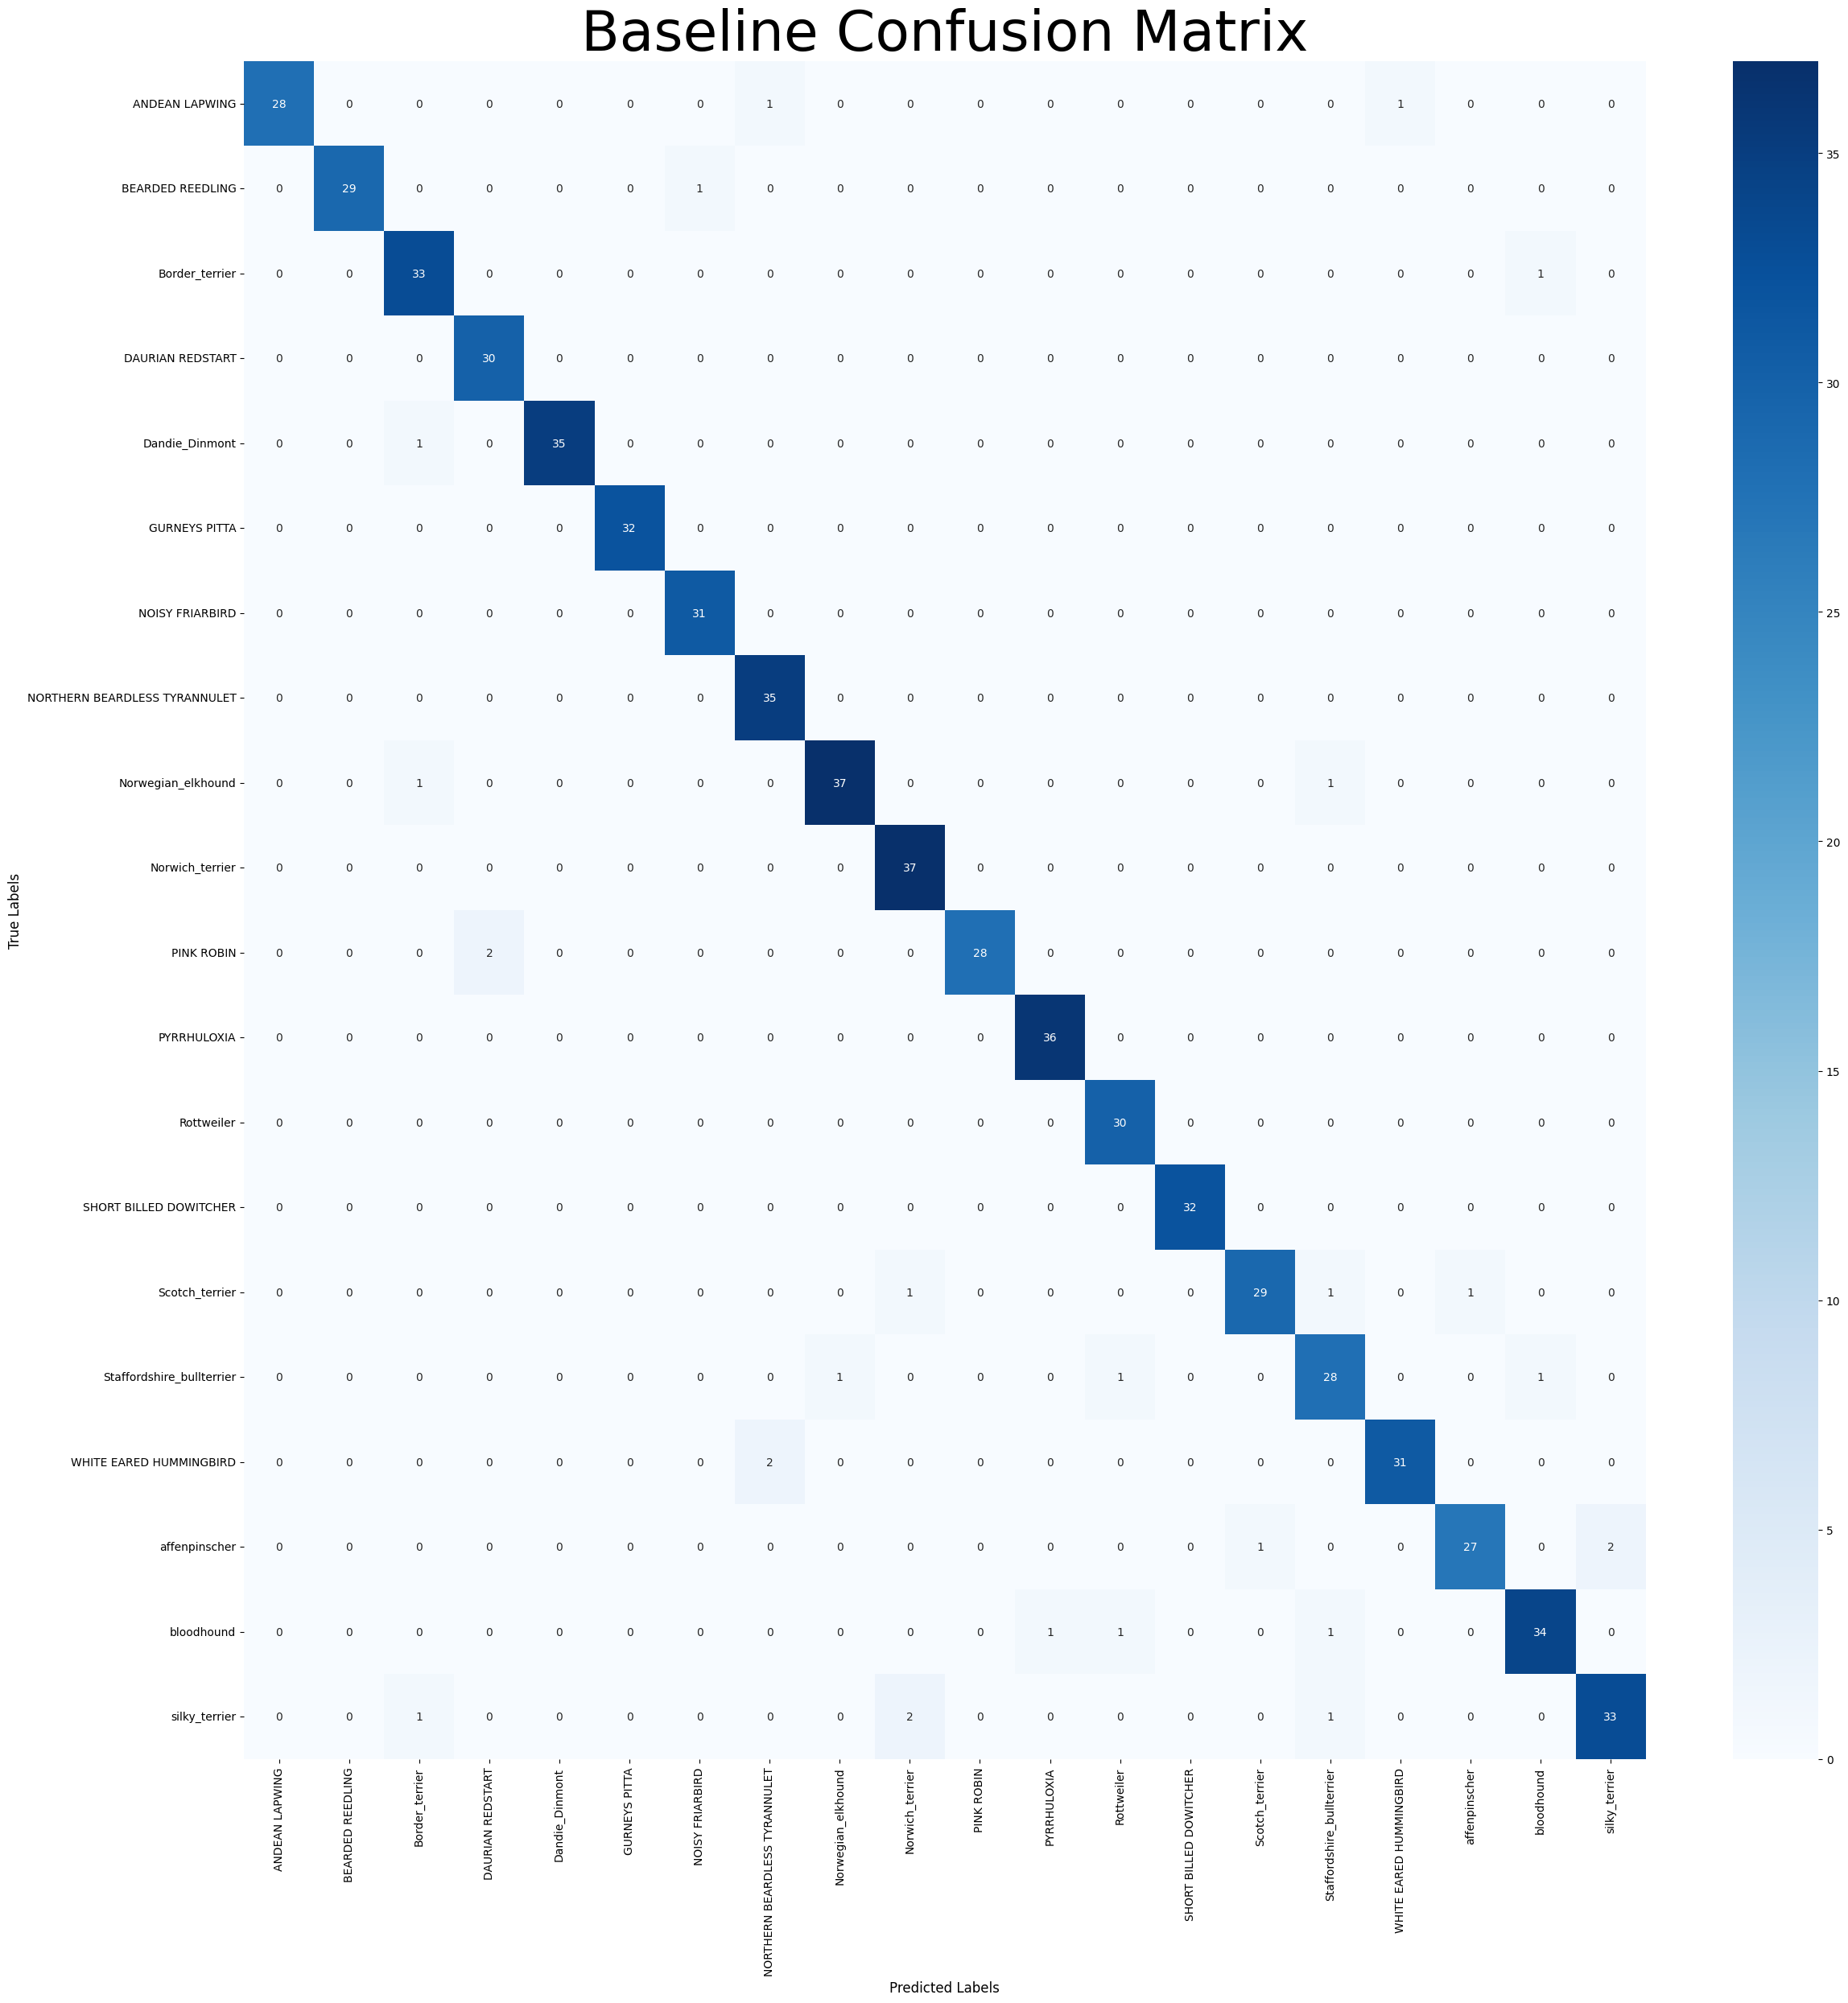

In [ ]:
# Load the best saved model from the checkpoint if necessary
model = load_model('/content/gdrive/MyDrive/42028/ass2/Image_Classification/weights/base_model_epoch_54-val_accuracy_0.96.h5')

# Get the true class indices from the test set, assuming that 'test_labels' contains true labels in one-hot encoding
true_classes = np.argmax(test_labels, axis=1)

# Predict the labels of the test images
predictions = model.predict(test_generator)

# Convert predictions from probabilities to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(25, 25))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Baseline Confusion Matrix', fontsize=50)
plt.ylabel('True Labels', fontsize=12)
plt.xlabel('Predicted Labels', fontsize=12)

# Plot adjustment
# Use the list of class names directly if class_labels is a list
class_names = class_labels  # Assuming class_labels is a list of class names in the correct order
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks + 0.5, class_names, rotation=90, fontsize=10)  # Offset by 0.5 to center the labels and adjust font size
plt.yticks(tick_marks + 0.5, class_names, rotation=360, fontsize=10)  # Adjust font size

plt.tight_layout()
plt.show()

## Customized MobileNetV2 Model

1. Adding more custom layers on top of the base model
2. Enhanced data augmentation
3. Setup checkpoint and reduce learning rate on plateau callbacks

In [ ]:
# Load the MobileNetV2 model with custom input shape
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True  # Set all layers trainable for fine-tuning

# Adding custom layers on top of the base model
custom_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1280, activation='relu'),
    BatchNormalization(),
    Dropout(0.6),
    Dense(640, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(class_labels), activation='softmax')
])


# Compile the custom model
custom_model.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='categorical_crossentropy', metrics=['accuracy'])

# Enhanced data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Setup the generators
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
validation_generator = validation_datagen.flow(val_images, val_labels, batch_size=32)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=32, shuffle=False)

# Setup checkpoint and reduce learning rate on plateau callbacks
checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/42028/ass2/Image_Classification/weights/custom_model_epoch_{epoch:02d}-val_accuracy_{val_accuracy:.2f}.h5', monitor='val_accuracy', save_best_only=True, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=0.00001, verbose=1)

# Model summary
custom_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 1280)              1639680   
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                      

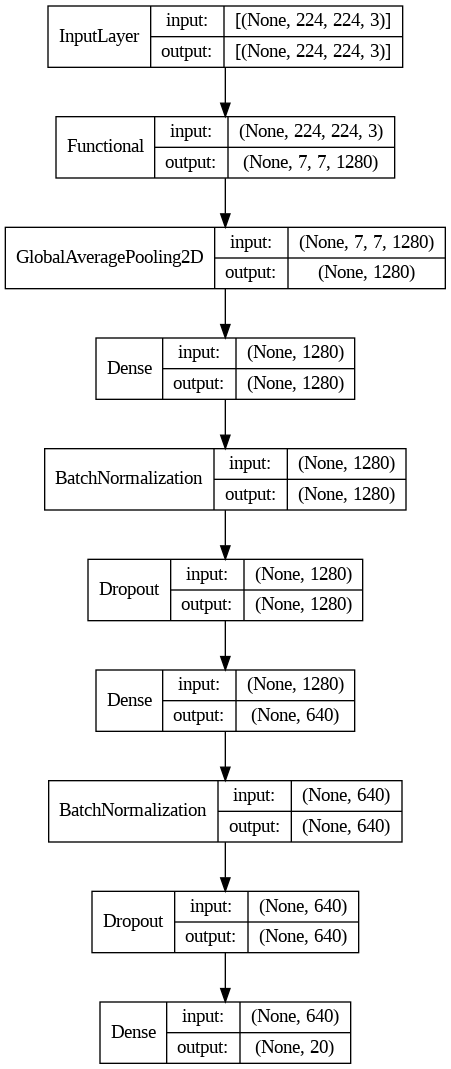

In [ ]:
# Using Plot_Model from Keras.Utils
model_img_file = '/content/gdrive/MyDrive/42028/ass2/Image_Classification/Custom-model.png'
tf.keras.utils.plot_model(custom_model, to_file=model_img_file,
                          show_shapes=True,
                          show_layer_activations=False,
                          show_dtype=False,
                          show_layer_names=False )

### Training the customized model

In [ ]:
# Train the custom model
history_custom = custom_model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[checkpoint, reduce_lr])

# Evaluate the custom model on the test set
test_loss_custom, test_acc_custom = custom_model.evaluate(test_generator)
print('Custom Test accuracy:', test_acc_custom)

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 2.9559 - accuracy: 0.2615
Epoch 1: val_accuracy improved from -inf to 0.78852, saving model to /content/gdrive/MyDrive/42028/ass2/Image_Classification/weights/custom_model_epoch_01-val_accuracy_0.79.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 60s 494ms/step - loss: 2.9559 - accuracy: 0.2615 - val_loss: 1.3668 - val_accuracy: 0.7885 - lr: 1.0000e-04
Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 1.2070 - accuracy: 0.6489
Epoch 2: val_accuracy improved from 0.78852 to 0.82477, saving model to /content/gdrive/MyDrive/42028/ass2/Image_Classification/weights/custom_model_epoch_02-val_accuracy_0.82.h5
63/63 [==============================] - 29s 459ms/step - loss: 1.2070 - accuracy: 0.6489 - val_loss: 0.6045 - val_accuracy: 0.8248 - lr: 1.0000e-04
Epoch 3/100
63/63 [==============================] - ETA: 0s - loss: 0.8151 - accuracy: 0.7557
Epoch 3: val_accuracy improved from 0.82477 to 0.85801, saving model to /content/gdrive/MyDrive/42028/ass2/Image_Classification/weights/custom_model_epoch_03-val_accuracy_0.86.h5
63/63 [==============================] - 31s 491ms/step - loss: 0.8151 - accuracy: 0.7557 - val_loss: 0.4018 - val_accuracy: 0.8580 - lr: 1.0000e-04
Epoch

### Visualize the results

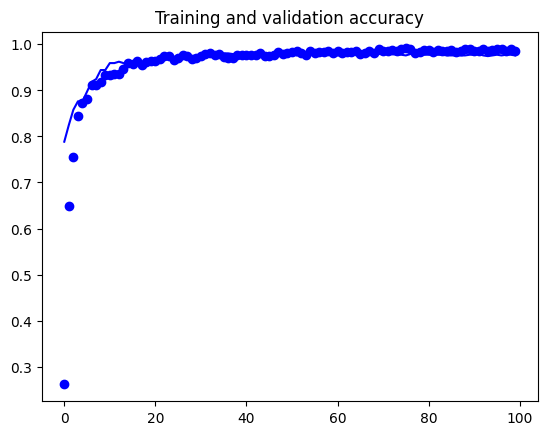

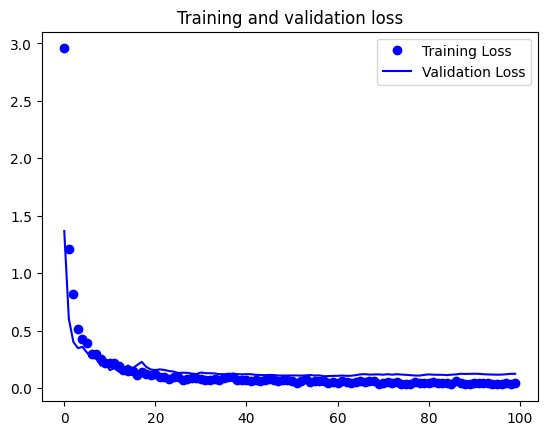

In [ ]:
acc = history_custom.history['accuracy']
val_acc = history_custom.history['val_accuracy']
loss = history_custom.history['loss']
val_loss = history_custom.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Extracting training and validation loss and accuracies
train_acc = history_custom.history['accuracy']
val_acc = history_custom.history['val_accuracy']
train_loss = history_custom.history['loss']
val_loss = history_custom.history['val_loss']

# Since we train for 100 epochs, we take the last values for train and validation
final_train_acc = train_acc[-1]
final_val_acc = val_acc[-1]
final_train_loss = train_loss[-1]
final_val_loss = val_loss[-1]

# Creating a DataFrame
performance_df = pd.DataFrame({
    'Set': ['Train', 'Validation', 'Test'],
    'Loss': [final_train_loss, final_val_loss, test_loss_custom],
    'Accuracy': [final_train_acc, final_val_acc, test_acc_custom]
})

# Display the table
print(performance_df)


# Optionally, save the table to a CSV file
# performance_df.to_csv('/mnt/data/baseline_performance.csv', index=False)


          Set      Loss  Accuracy
0       Train  0.043989  0.985894
1  Validation  0.124933  0.975831
2        Test  0.124863  0.974320


21/21 [==============================] - 2s 56ms/step


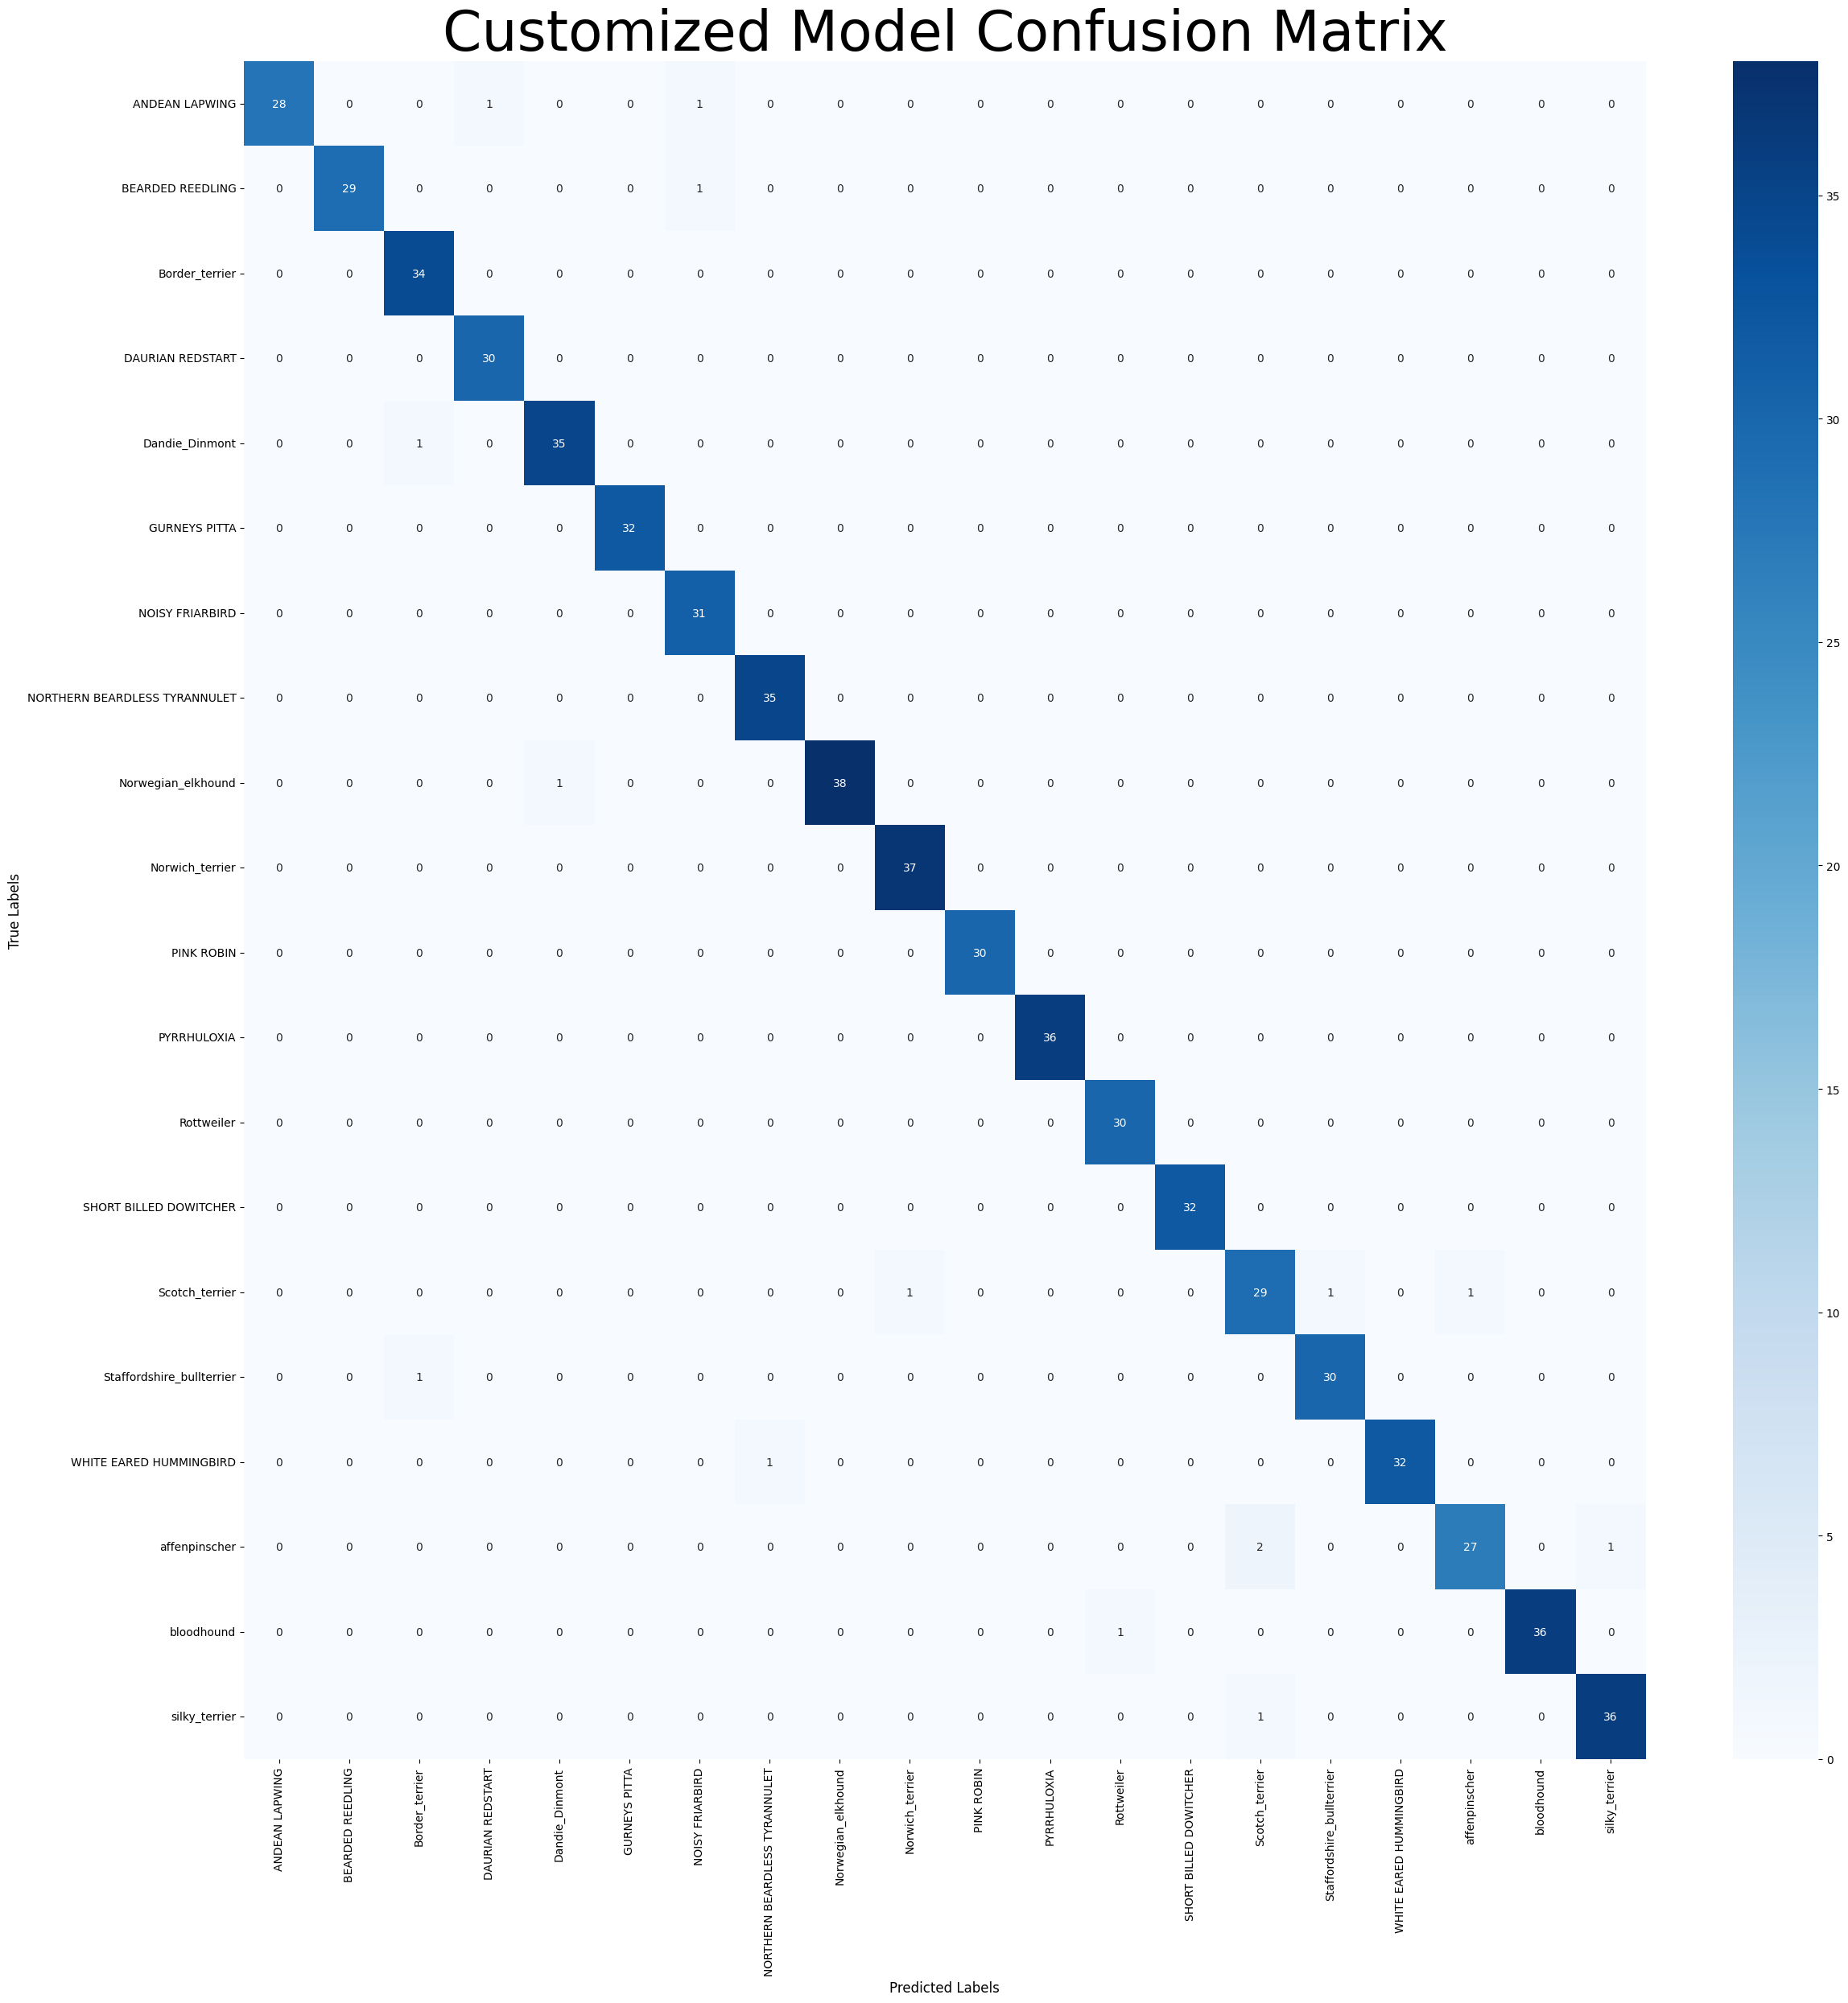

In [ ]:
# Load the best saved model from the checkpoint if necessary
model = load_model('/content/gdrive/MyDrive/42028/ass2/Image_Classification/weights/custom_model_epoch_36-val_accuracy_0.98.h5')

# Get the true class indices from the test set, assuming that 'test_labels' contains true labels in one-hot encoding
true_classes = np.argmax(test_labels, axis=1)

# Predict the labels of the test images
predictions = model.predict(test_generator)

# Convert predictions from probabilities to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(25, 25))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Customized Model Confusion Matrix', fontsize=50)
plt.ylabel('True Labels', fontsize=12)
plt.xlabel('Predicted Labels', fontsize=12)

# Plot adjustment
# Use the list of class names directly if class_labels is a list
class_names = class_labels  # Assuming class_labels is a list of class names in the correct order
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks + 0.5, class_names, rotation=90, fontsize=10)  # Offset by 0.5 to center the labels and adjust font size
plt.yticks(tick_marks + 0.5, class_names, rotation=360, fontsize=10)  # Adjust font size

plt.tight_layout()
plt.show()